# Xylo™-A3 `AFESim` Module Tutorial

Xylo™-A3 HDK contains a signal pre-processing module which is designed to encode an audio signal in the form of spike trains.
This module is named as **A**udio **F**ront-**E**nd, and it efficiently:

* captures audio from a microphone, 
* converts analog signals into digital waveforms, 
* performs band-pass filtering to isolate specific frequency ranges, 
* encodes signals into spike trains, 
* and ultimately delivers these spike trains to the Spiking Neural Network (SNN) core.

Here in this tutorial, we will introduce `AFESim`, the simulated counterpart of actual `AFE` module. This tutorial covers the usage and functionalities of `AFESim` in a beginner friendly manner.


## Getting Started

Let's first investigate the block diagram of the input pre-processing pipeline

In [1]:
from IPython.display import Image

Image("figures/av3_block.png")


`AFESim` can operate in 3 input mode
* "bypass"
* "pdm"
* "analog"

Selecting "bypass" mode will skip the microphone paths and directly feed the input to the band-pass filter. This mode is useful especially for debugging purposes. In this notebook, we'll first demonstrate the features of `AFESim` in "bypass" mode.

"pdm" mode enables us to simulate PDM microphone input. In this mode, `AFESim` will generate a PDM processed signal from the input audio file. This mode provides a full simulation of the input pre-processing pipeline.

"analog" mode simulates the other input path, which is the analog microphone input. In this mode, we simulate the analog microphone's process of converting analog signals into digital waveforms. (NOT YET IMPLEMENTED)

Both the "pdm" and "analog" modes are useful for simulating the full `AFE` operation in the absence of the actual hardware.

After the `SELECT_INPUT_SOURCE` mux, there comes:

* Filter Bank
* Divisive Normalization or IAF spike generation
* Rastering

The Filter bank is a set of 16 band-pass filters, optimized to cover the frequency range of the human voice. 
The output of each filter is a 14-bit integer signal. 
The output of the filter bank is a 16-channel 14-bit integer signal.

After the filter bank, the signal is passed through a divisive normalization block.
Divisive normalization provides a way to set dynamic, **adaptive thresholds** for spike generation depending on the instantaneous power of the signal.
The alternative path to the divisive normalization is the IAF spike generation block.
The IAF spike generation block generates spikes with a fixed threshold.

The output of the divisive normalization or the IAF spike generation block is 16-channel 1-bit spike trains.
This spike trains are accumulated in a 16-channel 4-bit rasters.
The rasters are the final output of the AFE block, and they are sent to the SNN core.

In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

from rockpool.devices.xylo.syns65302 import (
    AFESim,
    AUDIO_SAMPLING_RATE,
    PDM_FILTER_DECIMATION_FACTOR,
)
from rockpool.timeseries import TSContinuous, TSEvent


from samna.xyloA3.configuration import InputInterfaceConfig


## Load an audio file

To start with, we need to load an audio file. The audio file we'll use is a chirp signal whose frequency increases linearly from 20 Hz to 20 kHz in 4 seconds. The sampling rate of the audio file is ~1.5 MHz, but we'll downsample it to ~48.8 kHz. ~48.8 kHz is the nominal operation frequency of the signals. If you would like to try with your own audio file, please make sure that the sampling rate is the same. You can use `generate_chirp.py` to generate a new chirp signal. 

Let's load the audio file and plot the waveform! For the sake of visualisation, we will only use the first 0.1 second of the audio file.

In [3]:
# Load the audio recording using librosa

filename = "freq_sweep.wav"
signal, sr = librosa.load(filename, sr=None)

# Also load the frequency sweep data from the AFESim
freq_sw = np.load(filename.replace(".wav", ".npy"))


WARNING    /Users/ugurcancakal/rockpool/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
 [py.warnings]
  return f(*args, **kwargs)



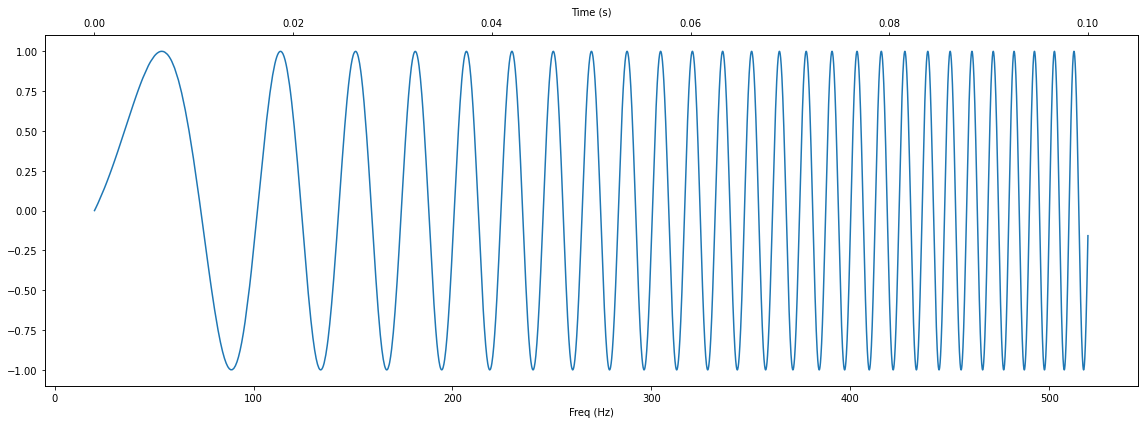

In [4]:
# - Plot the first 0.1 seconds of the audio recording


def plot_input_signal(signal, __freq_sw, sr, t=0.1):
    T = int(t * sr)
    fig, ax1 = plt.subplots(figsize=(16, 6))

    # - Plot the audio recording
    ax1.plot(__freq_sw[:T], signal[:T], alpha=0)
    ax1.xaxis.tick_bottom()
    ax1.set_xlabel("Freq (Hz)")
    ax1.xaxis.set_label_position("bottom")

    # - Plot the time axis
    ax2 = ax1.twiny()
    ax2.plot(np.arange(0, t, 1 / sr)[:T], signal[:T])
    ax2.xaxis.tick_top()
    ax2.set_xlabel("Time (s)")
    ax2.xaxis.set_label_position("top")

    plt.tight_layout()
    plt.show()


plot_input_signal(signal, freq_sw, sr, 0.1)


## Quantize and downsample the signal

The output of the microphone ADC's are both 14-bit integers. Also the nominal operating frequency is ~48.8 kHz. So, we need to quantize and downsample the signal to ~48.8 kHz, 14 bits.

In [5]:
scale = 1
num_bits = 14

# Downsample the signal
signal_down = librosa.resample(signal, sr, AUDIO_SAMPLING_RATE)

# Downsample freq_sw too
freq_sw_down = freq_sw[::PDM_FILTER_DECIMATION_FACTOR]

q_signal = np.vectorize(lambda __data: int(scale * __data * (2 ** (num_bits - 1))))(
    signal_down
)


WARNING    /var/folders/s3/p34fbr591yv5d_xqw53wdf1c0000gn/T/ipykernel_85491/2965035874.py:5: FutureWarning: Pass orig_sr=1562500, target_sr=48828.125 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal_down = librosa.resample(signal, sr, AUDIO_SAMPLING_RATE)
 [py.warnings]
  signal_down = librosa.resample(signal, sr, AUDIO_SAMPLING_RATE)



## Construct AFESim

There are two methods to construct an `AFESim` object. The first one is to use the default constructor. When we use the default constructor, we have all low-level hardware parameters. The second method is to use the `.from_specification()` method. `.from_specification()` provides us with a more human comprehensible way to construct an `AFESim` object, but it might not always be possible to select the exact parameters we want due to hardware constraints. It'll check and complain if there is any hardware constraint violation, and suggest the closest possible parameters.

Let's first use the default constructor in "bypass" mode. Later in this notebook, we'll investigate the other modes.

In [6]:
# - Utilize divisive normalization
afesim_dn = AFESim(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    input_mode="bypass",
    dn_rate_scale_bitshift=(6, 0),
    dn_low_pass_bitshift=12,
    dn_EPS=1,
    fixed_threshold_vec=None,
    down_sampling_factor=50,
)

# - Utilize IAF neurons
afesim_th = AFESim(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="threshold",
    input_mode="bypass",
    dn_rate_scale_bitshift=None,
    dn_low_pass_bitshift=None,
    dn_EPS=None,
    fixed_threshold_vec=2**27,
    down_sampling_factor=50,
)


Here we have two options for the spike generation mode:

* `divisive_norm`
* `threshold`

When we select `"divisive_norm"`, the divisive normalization block is used for spike generation. When we select `"threshold"`, the IAF spike generation block is used for spike generation.

In the case of `"divisive_norm"`, we have three parameters to control:

* `"dn_rate_scale_bitshift"`
* `"dn_low_pass_bitshift"`
* `"dn_EPS"`

`"fixed_threshold_vec"` is the parameter to control in the case of `"threshold"`. The `"fixed_threshold_vec"` is ignored in the case of `"divisive_norm"`, and the three parameters above are ignored in the case of `"threshold"`.


Let's check the docstring to see what these parameters are actually doing.

In [7]:
help(AFESim.__init__)


Help on function __init__ in module rockpool.devices.xylo.syns65302.afe_sim:

__init__(self, select_filters: 'Optional[Tuple[int]]' = None, spike_gen_mode: 'str' = 'divisive_norm', input_mode: 'str' = 'bypass', dn_rate_scale_bitshift: 'Optional[Tuple[int]]' = (6, 0), dn_low_pass_bitshift: 'Optional[int]' = 12, dn_EPS: 'Optional[Union[int, Tuple[int]]]' = 1, fixed_threshold_vec: 'Optional[Union[int, Tuple[int]]]' = 134217728, down_sampling_factor: 'int' = 50) -> 'None'
    AFESim constructor
    
    Args:
        select_filters (Optional[Tuple[int]], optional): The indices of the filters to be used in the filter bank. Defaults to None: use all filters.
            i.e. select_filters = (0,2,4,8,15) will use Filter 0, Filter 2, Filter 4, Filter 8, and Filter 15.
    
        spike_gen_mode (str, optional): The spike generation mode of the AFE. There are two ways to generate spikes, "divisive_norm" and "threshold". Defaults to "divisive_norm".
            When "divisive_norm" is selected

Now let's check the `from_specification()`. The similar `"divisive_norm"` vs. `"threshold"` distinction applies here as well. The difference is that we have more human comprehensible parameters to control.

In case of `"divisive_norm"`, we have:
* `"rate_scale_factor"` instead of `"dn_rate_scale_bitshift"`
* `"low_pass_averaging_window"` instead of `"dn_low_pass_bitshift"`

When we try to set the `"rate_scale_factor"`, it will automatically calculate the closest possible `"dn_rate_scale_bitshift"` value. The same applies to `"low_pass_averaging_window"` and `"dn_low_pass_bitshift"`.

Additionally, we have `"dt"` which corresponds to `"down_sampling_factor"`.

The rest of the parameters are the same as the default constructor. Let's print the docstring and see the connection between the parameters.


In [8]:
help(AFESim.from_specification)


Help on method from_specification in module rockpool.devices.xylo.syns65302.afe_sim:

from_specification(select_filters: 'Optional[Tuple[int]]' = None, spike_gen_mode: 'str' = 'divisive_norm', input_mode: 'str' = 'bypass', rate_scale_factor: 'Optional[int]' = 63, low_pass_averaging_window: 'Optional[float]' = 0.084, dn_EPS: 'Optional[Union[int, Tuple[int]]]' = 1, fixed_threshold_vec: 'Optional[Union[int, Tuple[int]]]' = None, dt: 'Optional[float]' = 0.001024, **kwargs) -> 'AFESim' method of rockpool.nn.modules.module.PostInitMetaMixin instance
    Create an instance of AFESim by specifying higher level parameters for AFESim.
    
    Args:
        select_filters (Optional[Tuple[int]], optional): Check :py:class:`.AFESim`. Defaults to None.
        spike_gen_mode (str, optional): Check :py:class:`.AFESim`. Defaults to "divisive_norm".
        input_mode (str, optional): Check :py:class:`.AFESim`. Defaults to "bypass".
        rate_scale_factor (Optional[int], optional): Target `rate_sca

Here we constructed the AFESim object from the specification, utilizing the divisive normalization block. Please feel free to play with the parameters and see how the output changes.

In [9]:
afesim = AFESim.from_specification(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    input_mode="bypass",
    rate_scale_factor=63,
    low_pass_averaging_window=84e-3,
    dn_EPS=1,
    fixed_threshold_vec=None,
    dt=1024e-6,
)


In [10]:
print("AFESim : ", afesim)
print("dt : ", afesim.dt)
print("low_pass_averaging_window : ", afesim.low_pass_averaging_window)
print("rate_scale_factor : ", afesim.rate_scale_factor)


AFESim :  AFESim  with shape (1, 16) {
    ChipButterworth '0_ChipButterworth' with shape (1, 16)
    DivisiveNormalization '1_DivisiveNormalization' with shape (16, 16)
    Raster '2_Raster' with shape (16, 16)
}
dt :  0.001024
low_pass_averaging_window :  0.08388608
rate_scale_factor :  63


## Run the simulation

We need to run the simulation to get the output. The output of the `AFESim` is a 16-channel 4-bit raster. However, there are also intermediate outputs which we can access. Below, we'll go through the outputs one by one.

First, let's run the simulation and get the output and the dictionaries.

In [11]:
out_bypass, state_bypass, rec_bypass = afesim(q_signal)


WARNING    /Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/syns65302/afe/divisive_normalization.py:338: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sig_in = jnp.asarray(sig_in, dtype=jnp.int64)
 [py.warnings]
  sig_in = jnp.asarray(sig_in, dtype=jnp.int64)

WARNING    /Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/syns65302/afe/divisive_normalization.py:340: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.c

Lets print the record dictionary and see what we have.

In [12]:
print(rec_bypass.keys())


dict_keys(['0_ChipButterworth', '0_ChipButterworth_output', '1_DivisiveNormalization', '1_DivisiveNormalization_output', '2_Raster', '2_Raster_output'])


## Filter Bank output

The first stage is the filterbank, and we can fetch the output with key `"0_ChipButterworth_output"`. The filterbank output is a 16-channel (max) 14-bit integer signal, which is the input to the divisive normalization block.

In the case we select a sub-set of channels through `"select_filters"`, the filterbank output will have exactly the selected number of channels.
Let's plot and observe the filtering effect!

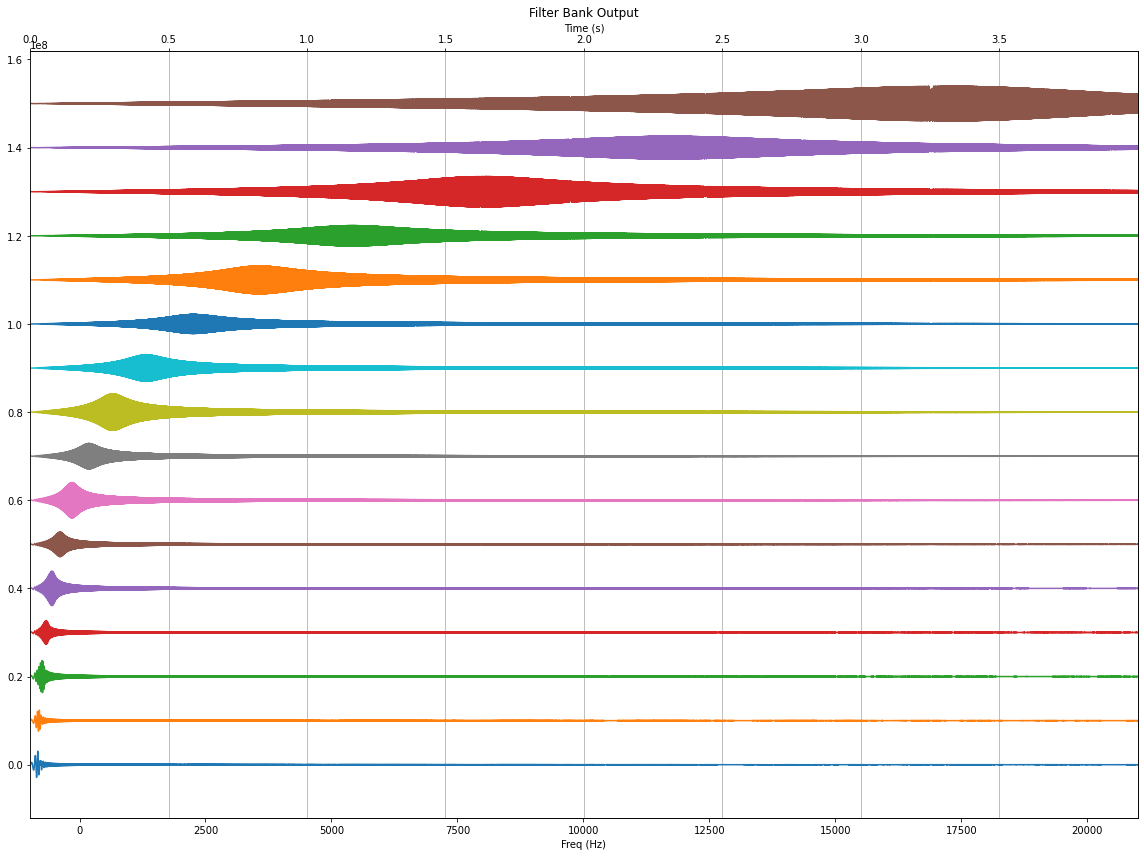

In [13]:
def plot_filter_bank_output(
    filtered_signal: np.ndarray, __freq_sw: np.ndarray, __sr: float
) -> None:
    fig, ax1 = plt.subplots(figsize=(16, 12))

    # - Plot the frequency sweep
    ax1.plot(__freq_sw, filtered_signal, alpha=0)
    ax1.xaxis.tick_bottom()
    ax1.set_xlabel("Freq (Hz)")
    ax1.xaxis.set_label_position("bottom")

    # - Plot the time axis
    ax2 = ax1.twiny()
    plt.sca(ax2)
    TSContinuous.from_clocked(filtered_signal, dt=1 / __sr).plot(stagger=1e7)
    ax2.xaxis.tick_top()
    ax2.set_xlabel("Time (s)")
    ax2.xaxis.set_label_position("top")

    # - Plot
    plt.title("Filter Bank Output")
    plt.tight_layout()
    plt.grid()
    plt.show()


plot_filter_bank_output(
    rec_bypass["0_ChipButterworth_output"], freq_sw_down, AUDIO_SAMPLING_RATE
)


As we can see, different filter channels apply different band-pass filters to the input signal. The lower index channels pass lower band frequencies, and the higher index channels higher band frequencies.

## Spike Encoding

The second stage is the spike generation, and we can fetch the output with key `"1_DivisiveNormalization_output"`. The divisive normalization output is 16-channel (max) **1-bit** spike train.

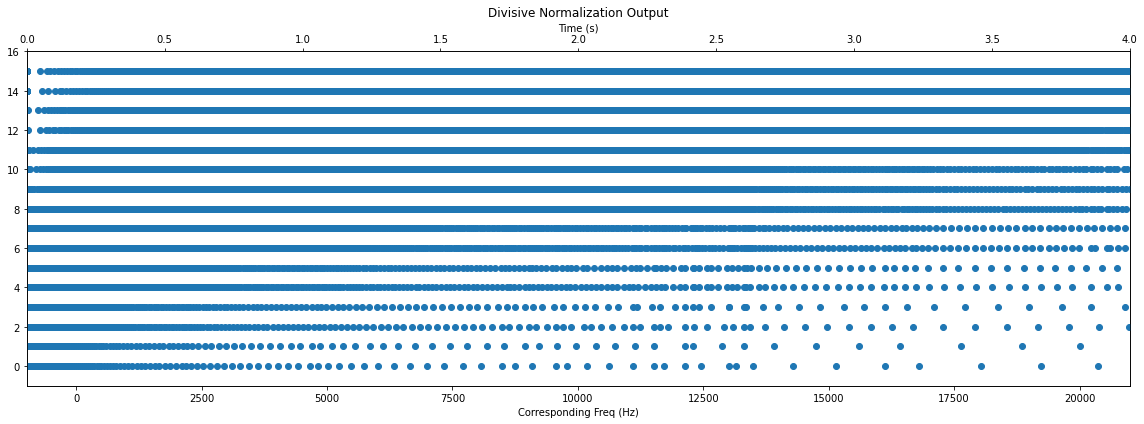

In [14]:
def plot_divisive_normalization_output(
    spike_out: np.ndarray, __freq_sw: np.ndarray, __sr: float
) -> None:
    fig, ax = plt.subplots(figsize=(16, 6))

    # - Plot the frequency sweep
    ax.plot(__freq_sw, spike_out, alpha=0)
    ax.xaxis.tick_bottom()
    ax.set_xlabel("Corresponding Freq (Hz)")
    ax.xaxis.set_label_position("bottom")

    # - Plot the time axis
    ax_twin = ax.twiny()
    plt.sca(ax_twin)
    TSEvent.from_raster(spike_out, dt=1 / __sr).plot()
    ax_twin.xaxis.tick_top()
    ax_twin.set_xlabel("Time (s)")
    ax_twin.xaxis.set_label_position("top")

    # - Plot
    plt.title("Divisive Normalization Output")
    plt.tight_layout()
    plt.show()


plot_divisive_normalization_output(
    rec_bypass["1_DivisiveNormalization_output"], freq_sw_down, AUDIO_SAMPLING_RATE
)


Here the the figure shows the 1-bit 16 channel spike train obtained at the output of the divisive normalization block. We can see that the spikes are densely distributed in the high power regions of the signal.

## Accumulated spikes

Even though the spike encoding obtained at the output of the divisive normalization block is sufficient for the SNN core, we can also accumulate the spikes in a 16-channel 4-bit raster. This provides us with a lower SNN clock rate, and better power efficiency. For that reason, we have the rastering block. Rastering block accumulates spikes given the `"down_sampling_factor"` set at the construction of the `AFESim` object.

In [15]:
afesim.down_sampling_factor


50

`"down_sampling_factor"` = 50 means that the rastering block accumulates 50 timesteps of spikes into a single timestep. This means that the SNN core will run at 50 times lower clock rate compared to the AFE block.

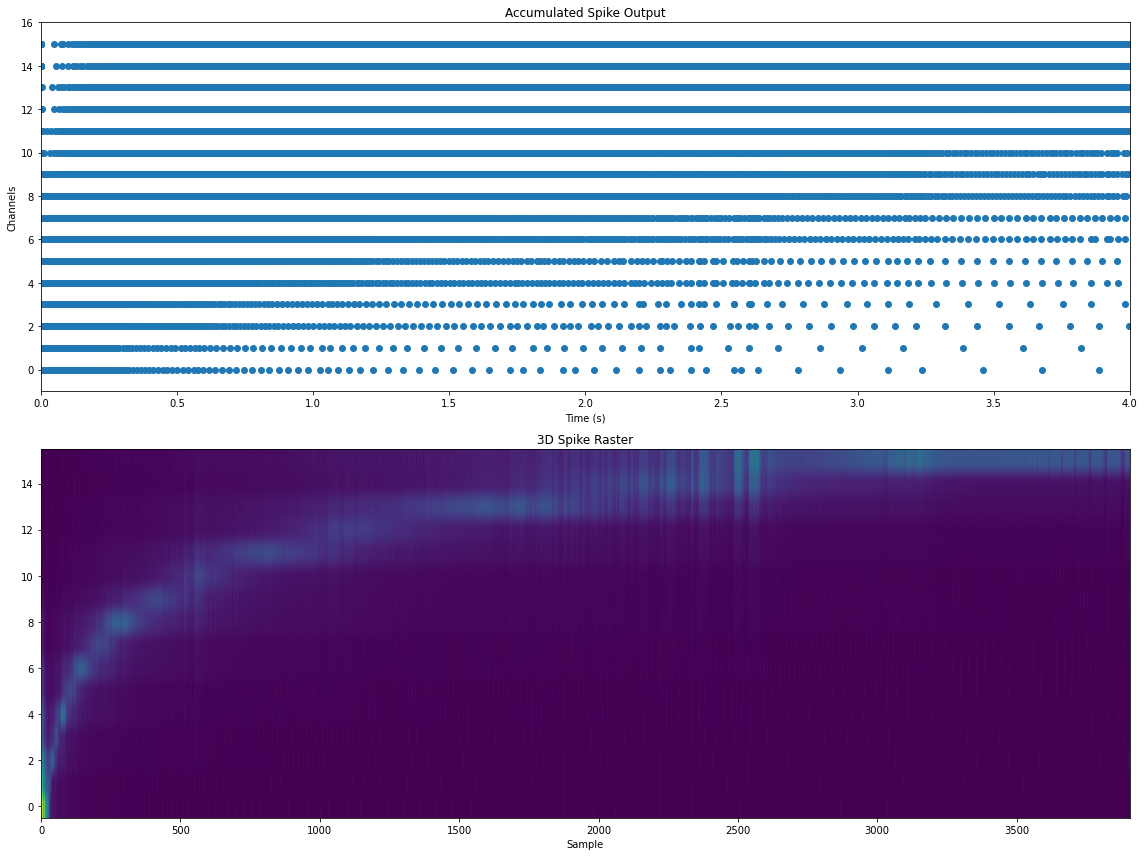

In [16]:
def plot_raster_output(out: np.ndarray, dt: float) -> None:
    fig, axs = plt.subplots(2, 1, figsize=(16, 12))

    # - Plot the raster
    plt.sca(axs[0])
    TSEvent.from_raster(out, dt=dt).plot()

    # - Plot the 3D image of the raster, color encoding the number of spikes
    axs[1].imshow(out.T, aspect="auto", origin="lower")
    axs[1].set_xlabel("Sample")
    axs[1].set_title("3D Spike Raster")

    plt.title("Accumulated Spike Output")
    plt.tight_layout()
    plt.show()


plot_raster_output(out_bypass, dt=afesim.dt)


Due to that down-sampling, and accumulation into a 4-bit spike representation, now the spike raster plot is not self-sufficient to visualize the output. The second figure encodes the number of spikes in one timestep into the color of the pixel. The greener the pixel, the more spikes are accumulated in that timestep.

## PDM input

Now we know what to see at the intermediate states and the output of the `AFESim`. Let's investigate the other input modes.
First we'll construct the `AFESim` object with `"pdm"` input mode. When we do this, we do not need to quantize the signal by hand, since the `PDMADC` module will do it for us.

In [17]:
afesim_pdm = AFESim.from_specification(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    input_mode="pdm",
    rate_scale_factor=63,
    low_pass_averaging_window=84e-3,
    dn_EPS=1,
    fixed_threshold_vec=None,
    dt=1024e-6,
)


In [18]:
afesim_pdm


AFESim  with shape (1, 16) {
    PDMADC '0_PDMADC' with shape (1, 1) {
        MicrophonePDM '0_MicrophonePDM' with shape (1,)
        PolyPhaseFIR '1_PolyPhaseFIR' with shape (1,)
    }
    ChipButterworth '1_ChipButterworth' with shape (1, 16)
    DivisiveNormalization '2_DivisiveNormalization' with shape (16, 16)
    Raster '3_Raster' with shape (16, 16)
}

## PDM included simulation requires amplitude scaling

The delta sigma module inside the `PDMADC` is subject to divergence when the input signal amplitude hits the boundaries of the valid amplitude range [+1, -1]. For that reason, we need to scale the input signal to avoid divergence. The details of this effect is explained in detail in the following tutorial:

To avoid divergence, we scaled the input signal by a factor of `0.9`. We'll use the original signal here, instead of using down-sampled one.

In [19]:
__scale = 0.9
out_pdm, state_pdm, rec_pdm = afesim_pdm((signal * __scale, sr))


WARNING    /Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/syns65302/afe/divisive_normalization.py:338: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sig_in = jnp.asarray(sig_in, dtype=jnp.int64)
 [py.warnings]
  sig_in = jnp.asarray(sig_in, dtype=jnp.int64)

WARNING    /Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/syns65302/afe/divisive_normalization.py:340: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.c

## Get rid of the transition period

First 8 samples of the PDM signal is a transition period. We need to get rid of this transition period to get a clean PDM signal. We can observe that, even though we used the oversampled signal, PDM handles the downsampling by itself.

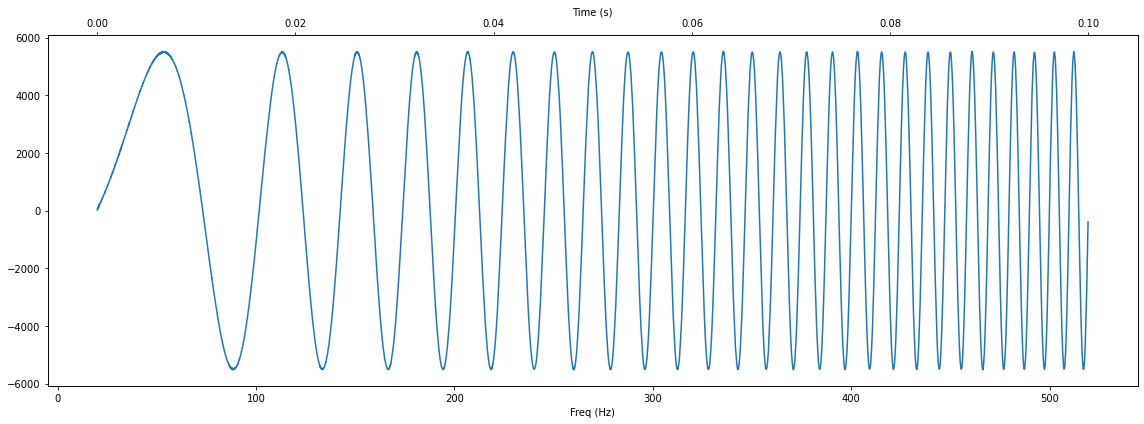

In [20]:
ignore_first = 8
plot_input_signal(
    rec_pdm["0_PDMADC_output"][ignore_first:], freq_sw_down, AUDIO_SAMPLING_RATE, t=0.10
)


## Filter Bank output

Filter bank output is a bit shifted in comparison to the "bypass" mode. This is due to the fact that the PDM microphone path contains a low pass filter, which introduces a delay. Since the sample signal is a fast frequency changing chirp, the delay is more visible. In the case of a speech signal, this delay is not visible because the frequency changes are not as fast as the chirp signal.

You can try to use a speech signal and observe the difference in the filter bank output. Or you can generate a longer chirp to observe that the effect of lag is less prominent.

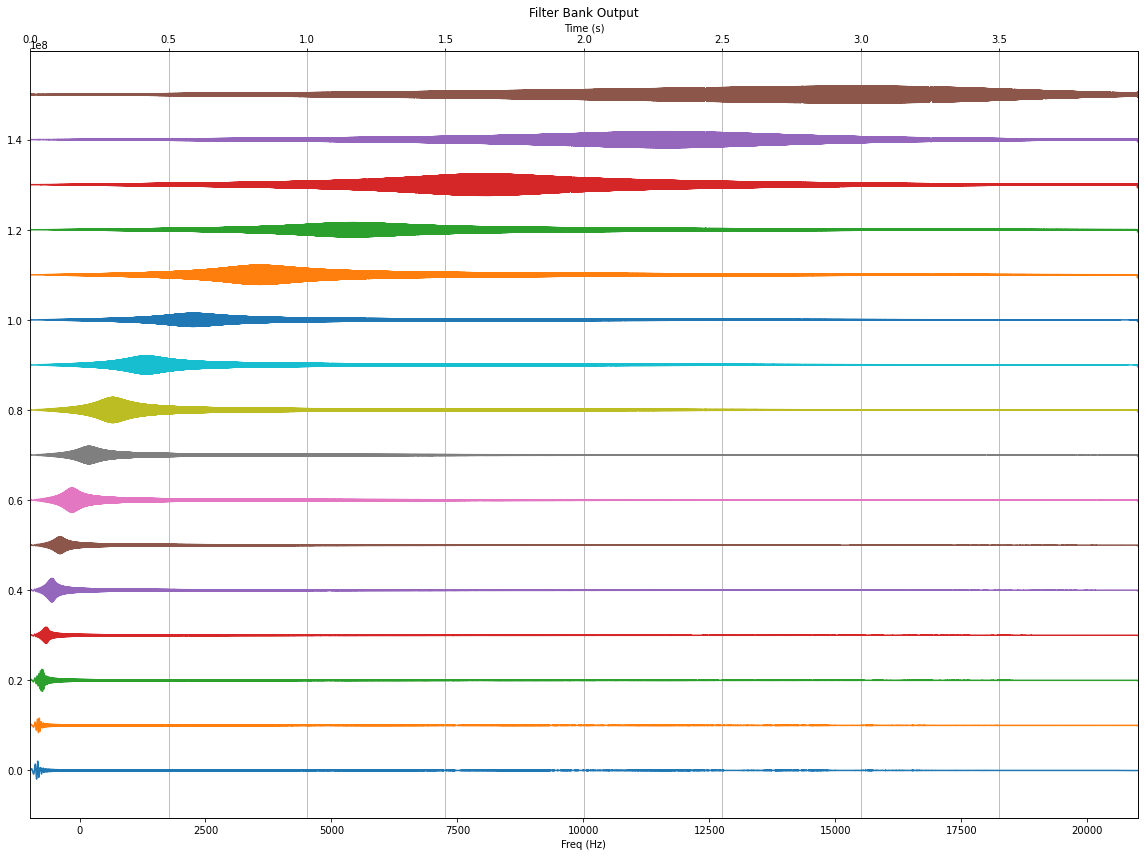

In [21]:
plot_filter_bank_output(
    rec_pdm["1_ChipButterworth_output"][ignore_first:],
    freq_sw_down,
    AUDIO_SAMPLING_RATE,
)


## Spike Encoding

We can observe the similar characteristics in the spike encoding. The pattern is behaving similarly, but the spike timings are a bit shifted due to the delay introduced by the low pass filter. The 3D spike raster at the end of the notebook presents a similar pattern we observed previously.

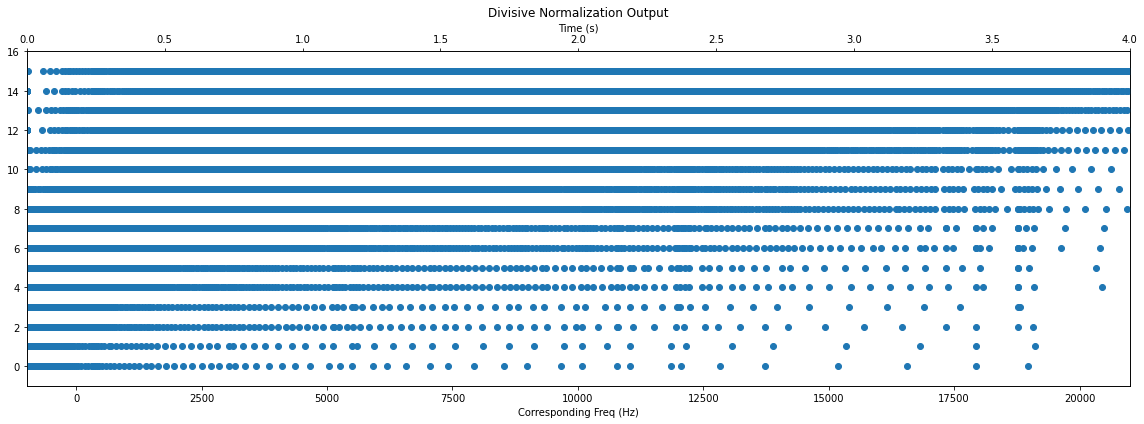

In [22]:
plot_divisive_normalization_output(
    rec_pdm["2_DivisiveNormalization_output"][ignore_first:],
    freq_sw_down,
    AUDIO_SAMPLING_RATE,
)


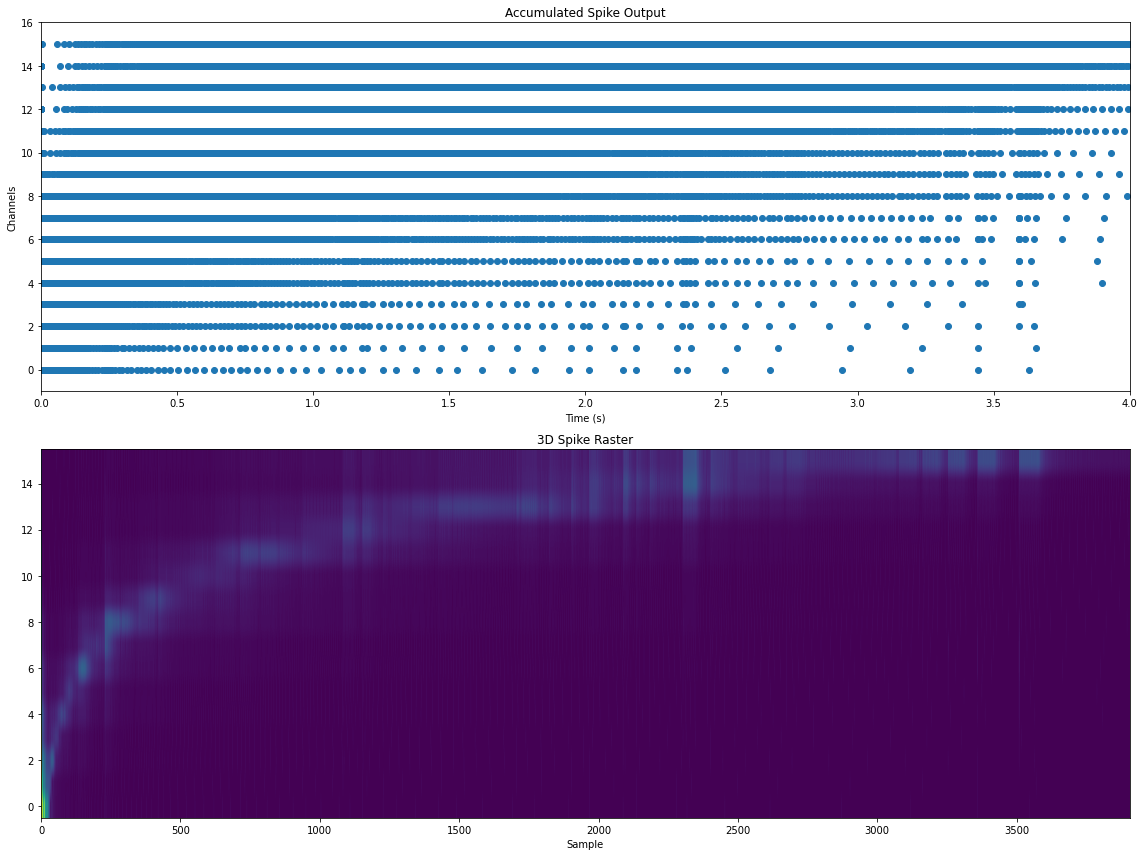

In [23]:
plot_raster_output(out_pdm, dt=afesim_pdm.dt)
